In [85]:
%pip install pandas nltk sacrebleu rouge-score sentence-transformers bert-score numpy matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [86]:
import os
import pandas as pd
from sacrebleu.metrics import BLEU as SacreBLEU
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer, util

In [87]:
def load_json(file_path):
    return pd.read_json(file_path)

In [88]:
DOMAIN_MODELS = [
    "cisco-ai/SecureBERT2.0-base",
    "selfconstruct3d/AttackGroup-MPNET",
    "attack-vector/SecureModernBERT-NER",
    "ibm-research/CTI-BERT",
    "basel/ATTACK-BERT"
]

# Cache the models
domain_embeddings = {name: SentenceTransformer(name) for name in DOMAIN_MODELS}

def compute_text_metrics(threat_text, scenario_text):
    # SacreBLEU
    sbleu = SacreBLEU().corpus_score([scenario_text], [[threat_text]]).score

    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge = scorer.score(threat_text, scenario_text)['rougeL'].fmeasure

    # Semantic similarity with domain models
    sim_scores = {}
    for name, model in domain_embeddings.items():
        emb1 = model.encode(threat_text, convert_to_tensor=True)
        emb2 = model.encode(scenario_text, convert_to_tensor=True)
        sim_scores[f"Similarity_{name.split('/')[-1]}"] = float(util.cos_sim(emb1, emb2).item())

    results = {
        "SacreBLEU": sbleu,
        "ROUGE-L": rouge,
        **sim_scores
    }

    return results

Some weights of BertModel were not initialized from the model checkpoint at ibm-research/CTI-BERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [89]:
def merge_and_score(orig_df, ai_df):
    results = []

    for _, row1 in orig_df.iterrows():
        for _, row2 in ai_df.iterrows():

            # Match Category/Threat Type
            if row1['Category'] == row2['Threat Type']:
                combined_threat = row1['Threat']
                combined_scenario = row2['Scenario']

                metrics = compute_text_metrics(combined_threat, combined_scenario)

                results.append({
                    "Category": row1['Category'],
                    "Threat": combined_threat,
                    "Scenario": combined_scenario,
                    **metrics
                })

    return pd.DataFrame(results)

In [102]:
def visualize_scores(df, title="Threat Similarity Metrics"):
    metrics = [
        "Similarity_SecureBERT2.0-base",
        "Similarity_AttackGroup-MPNET",
        "Similarity_SecureModernBERT-NER",
        "Similarity_CTI-BERT",
        "Similarity_ATTACK-BERT"
    ]

    # Extract values for the metrics
    data = df[metrics].values

    num_items = data.shape[0]
    num_metrics = len(metrics)

    # Set bar positions
    x = np.arange(num_metrics)
    width = 0.8 / num_items  # adjust bar width based on number of rows

    plt.figure(figsize=(12, 6))

    for i in range(num_items):
        plt.bar(
            x + i * width,
            data[i],
            width,
            label=f"Pair {i+1}"
        )

    # Formatting
    plt.xticks(x + width * (num_items - 1) / 2, metrics, rotation=45)
    plt.ylabel("Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [99]:
def get_similar_pairs_all_metrics(results_df, print_it=False, sbleu=1, rouge=0.1, bert=0.5):
    similar = results_df[
        (results_df['SacreBLEU'] >= sbleu) &
        (results_df['ROUGE-L'] >= rouge) &
        (results_df['Similarity_SecureBERT2.0-base'] >= bert) &
        (results_df['Similarity_AttackGroup-MPNET'] >= bert) &
        (results_df['Similarity_SecureModernBERT-NER'] >= bert) &
        (results_df['Similarity_CTI-BERT'] >= bert) &
        (results_df['Similarity_ATTACK-BERT'] >= bert)
    ]
    
    if print_it:
        for idx, row in similar.iterrows():
            print(f"Category: {row['Category']}")
            print(f"Threat: {row['Threat']}")
            print(f"Scenario: {row['Scenario']}")
            print(f"SacreBLEU: {row['SacreBLEU']:.2f}")
            print(f"ROUGE-L: {row['ROUGE-L']:.2f}")
            print(f"Similarity_SecureBERT2.0-base: {row['Similarity_SecureBERT2.0-base']:.2f}")
            print(f"Similarity_AttackGroup-MPNET: {row['Similarity_AttackGroup-MPNET']:.2f}")
            print(f"Similarity_SecureModernBERT-NER: {row['Similarity_SecureModernBERT-NER']:.2f}")
            print(f"Similarity_CTI-BERT: {row['Similarity_CTI-BERT']:.2f}")
            print(f"Similarity_ATTACK-BERT: {row['Similarity_ATTACK-BERT']:.2f}")
            print("-" * 80)
    
    return similar

In [ ]:
# COMPARE CHATGPT AND ORIGINAL MODEL
original_df = load_json("threat_model.json")
chatgpt_df = load_json("chatgpt.json")

merged_chatgpt_df = merge_and_score(original_df, chatgpt_df)

# COMPARE GEMINI AND ORIGINAL MODEL
original_df = load_json("threat_model.json")
gemini_df = load_json("gemini.json")

merged_gemini_df = merge_and_score(original_df, gemini_df)

# COMPARE Le CHAT AND ORIGINAL MODEL
original_df = load_json("threat_model.json")
lechat_df = load_json("le_chat.json")

merged_lechat_df = merge_and_score(original_df, lechat_df)

Total similar pairs found: 0 out of 39
Percentage: 0.00%


In [117]:
similar_pairs_chatgpt = get_similar_pairs_all_metrics(merged_chatgpt_df)
similar_pairs_chatgpt.to_json("similar_pairs_chatgpt.json", orient="records", lines=False, force_ascii=False)
unique_threats_chatgpt = similar_pairs_chatgpt['Threat'].unique()

print(f"Total similar pairs found: {len(similar_pairs_chatgpt)} out of {len(merged_chatgpt_df)}")
print(f"Total number of unique threats: {len(unique_threats_chatgpt)} out of {len(original_df)}")
print(f"Percentage: {len(similar_pairs_chatgpt) / len(merged_chatgpt_df) * 100:.2f}%")
print()


similar_pairs_gemini = get_similar_pairs_all_metrics(merged_gemini_df)
similar_pairs_gemini.to_json("similar_pairs_gemini.json", orient="records", lines=False, force_ascii=False)
unique_threats_gemini = similar_pairs_gemini['Threat'].unique()
    
print(f"Total similar pairs found: {len(similar_pairs_gemini)} out of {len(merged_gemini_df)}")
print(f"Total number of unique threats: {len(unique_threats_gemini)} out of {len(original_df)}")
print(f"Percentage: {len(similar_pairs_gemini) / len(merged_gemini_df) * 100:.2f}%")
print()


similar_pairs_lechat = get_similar_pairs_all_metrics(merged_lechat_df)
similar_pairs_lechat.to_json("similar_pairs_lechat.json", orient="records", lines=False, force_ascii=False)
unique_threats_lechat = similar_pairs_lechat['Threat'].unique()
    
print(f"Total similar pairs found: {len(similar_pairs_lechat)} out of {len(merged_lechat_df)}")
print(f"Total number of unique threats: {len(unique_threats_lechat)} out of {len(original_df)}")
print(f"Percentage: {len(similar_pairs_lechat) / len(merged_lechat_df) * 100:.2f}%")
print()

same_threats = set(unique_threats_chatgpt) & set(unique_threats_gemini) & set(unique_threats_lechat)
print(f"Total number of overlapping threats between the different models': {len(same_threats)}")
for threat in same_threats:
    print(threat)

Total similar pairs found: 9 out of 39
Total number of unique threats: 7 out of 13
Percentage: 23.08%

Total similar pairs found: 14 out of 39
Total number of unique threats: 7 out of 13
Percentage: 35.90%

Total similar pairs found: 17 out of 39
Total number of unique threats: 8 out of 13
Percentage: 43.59%

Total number of overlapping threats between the different models': 5
An attacker could put a fake message on queue, causing the Background Worker to do incorrect processing.
The Background Worker Config stores the credentials used by the Background Worker to access the Database. An attacker could compromise the Background Worker and get access to the Database credentials.
An attacker could obtain the Database credentials and use them to make unauthorised queries.
The Web Application Config stores credentials used  by the Web Application to access the Message Queue. These could be stolen by an attacker and used to read confidential data or place poisoned messages on the queue.
Mess

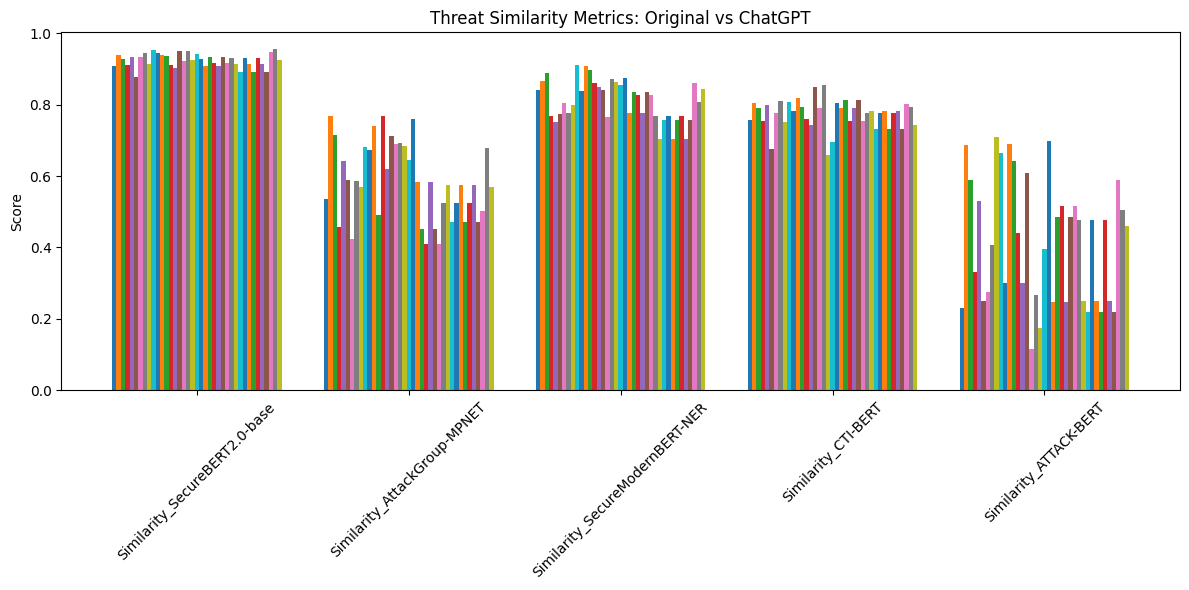

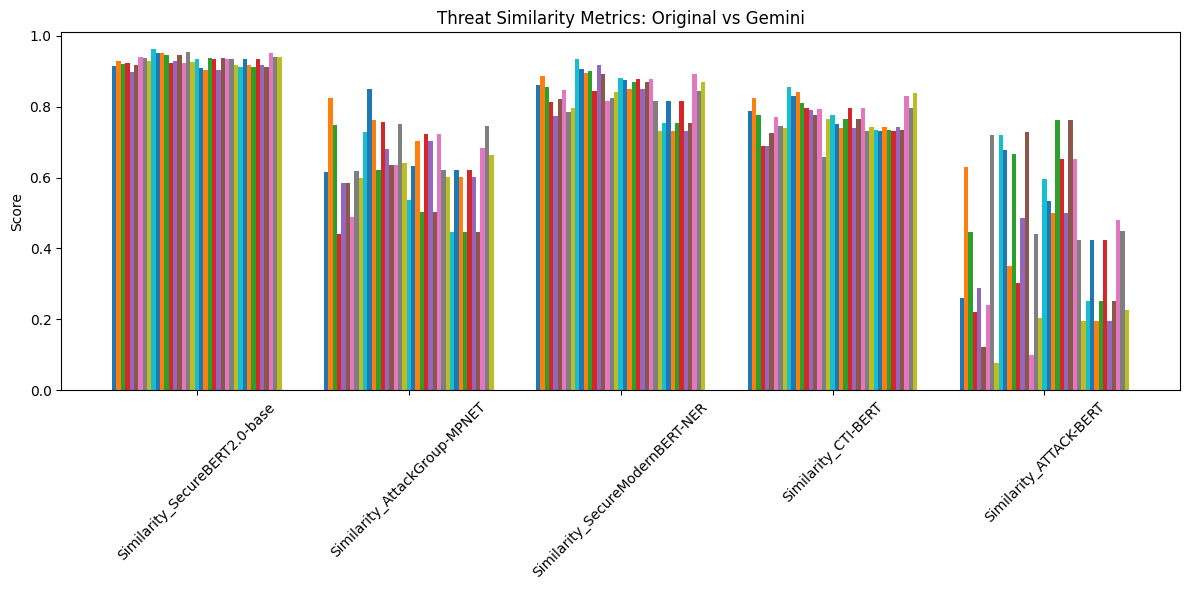

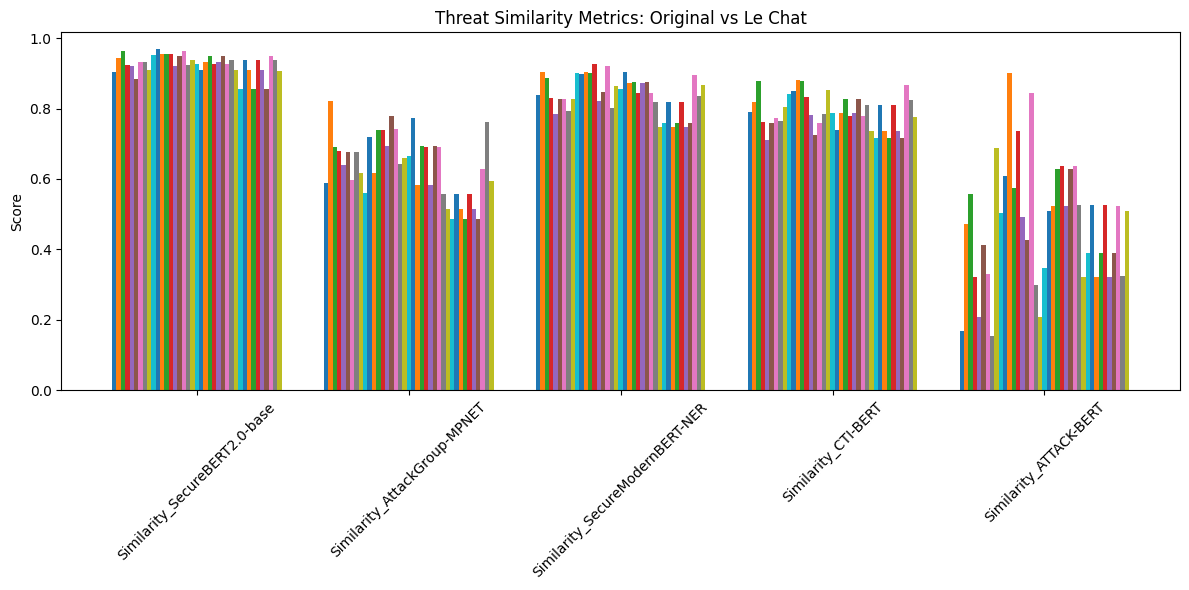

In [103]:
visualize_scores(merged_chatgpt_df, title="Threat Similarity Metrics: Original vs ChatGPT")
visualize_scores(merged_gemini_df, title="Threat Similarity Metrics: Original vs Gemini")
visualize_scores(merged_lechat_df, title="Threat Similarity Metrics: Original vs Le Chat")